In [9]:
import sys
import os
current_dir = os.getcwd()
sys.path.append(current_dir)

import scvelo as scv
import scanpy 
import loompy
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib
import numpy as np
import anndata 
import pandas as pd
import cellrank as cr
import scipy
import h5py


cr.settings.verbosity = 4
from scipy import sparse

import pandas as pd
import loompy


plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.size"] = 7
transparency = True
ms=0.7
labelspacing=0.3
viridis_grey  = (239/256, 239/256, 240/256,1)




import scatterm as scatterm_mod
import helper_utils as own_utils
import mplt as mplot

ofolder = os.path.join(current_dir,'lineages_params')

In [21]:
clu_colour = {'0': [0.9375, 0.63671875, 0.99609375],
 '1': [0.0, 0.45703125, 0.859375],
 '10': [0.59765625, 0.24609375, 0.0],
 '11': [0.296875, 0.0, 0.359375],
 '12': [0.0, 0.359375, 0.19140625],
 '13': [0.16796875, 0.8046875, 0.28125],
 '14': [0.99609375, 0.796875, 0.59765625],
 '15': [0.5, 0.5, 0.5],
 '16': [0.578125, 0.99609375, 0.70703125],
 '17': [0.55859375, 0.484375, 0.0],
 '18': [0.61328125, 0.796875, 0.0],
 '19': [0.7578125, 0.0, 0.53125],
 '2': [0.0, 0.19921875, 0.5],
 '20': [0.99609375, 0.640625, 0.01953125],
 '21': [0.99609375, 0.65625, 0.73046875],
 '22': [0.2578125, 0.3984375, 0.0],
 '23': [0.99609375, 0.0, 0.0625],
 '24': [0.3671875, 0.94140625, 0.9453125],
 '25': [0.0, 0.59765625, 0.55859375],
 '26': [0.875, 0.99609375, 0.3984375],
 '27': [0.453125, 0.0390625, 0.99609375],
 '28': [0.59765625, 0.0, 0.0],
 '29': [0.99609375, 0.99609375, 0.5],
 '3': [0.99609375, 0.99609375, 0.0],
 '30': [0.99609375, 0.3125, 0.01953125],
 '31': [0.96875, 0.818359375, 0.998046875],
 '32': [0.5, 0.728515625, 0.9296875],
 '33': [0.798828125, 0.623046875, 0.5],
 '34': [0.6484375, 0.5, 0.6796875],
 '35': [0.5, 0.6796875, 0.595703125],
 '36': [0.583984375, 0.90234375, 0.640625],
 '37': [0.998046875, 0.8984375, 0.798828125],
 '38': [0.75, 0.75, 0.75],
 '39': [0.7890625, 0.998046875, 0.853515625],
 '4': [0.779296875, 0.7421875, 0.5],
 '40': [0.806640625, 0.8984375, 0.5],
 '41': [0.87890625, 0.5, 0.765625],
 '42': [0.5, 0.599609375, 0.75],
 '43': [0.998046875, 0.8203125, 0.509765625],
 '44': [0.998046875, 0.828125, 0.865234375],
 '45': [0.62890625, 0.69921875, 0.5],
 '46': [0.998046875, 0.5, 0.53125],
 '47': [0.68359375, 0.970703125, 0.97265625],
 '5': [0.5, 0.798828125, 0.779296875],
 '6': [0.9375, 0.998046875, 0.69921875],
 '7': [0.7265625, 0.51953125, 0.998046875],
 '8': [0.798828125, 0.5, 0.5],
 '9': [0.998046875, 0.998046875, 0.75]}

class_color = {'Neuron': '#5384db',
 'Neuroblast': '#5d25c4',
 'Neuronal IPC': '#ab3bc4',
 'Radial glia': '#27b35d',
 'Glioblast': '#447c69',
 'Oligo': '#9cba19',
 'Fibroblast': '#c48351',
 'Neural crest': '#eec79f',
 'Placodes': '#70510e',
 'Immune': '#e7c31f',
 'Vascular': '#e12e12',
 'Erythrocyte': '#ff617f',
 'Failed': '#9f9f9f'}

class_color_ = dict()
for k,v in class_color.items():
    class_color_[k] = matplotlib.colors.to_rgb(v)


age_colour = [[0.43529411, 0.23921568, 0.58039215, 1.],
[0.26905037, 0.45397924, 0.70349865, 1.],
[0.45490196, 0.67843137, 0.81960784, 1.],
[0.66635909, 0.84759708, 0.91188005, 1.],
[0.87843137, 0.95294118, 0.97254902, 1.],
[0.99607843, 0.87843137, 0.56470588, 1.],
[0.99146482, 0.67735486, 0.37808535, 1.],
[0.95686275, 0.42745098, 0.26274510, 1.],
[0.83929258, 0.18454441, 0.15286428, 1.]]

age_colour = matplotlib.colors.ListedColormap(age_colour)
attr_colour = {'Clusters':clu_colour,'Age':age_colour,'Cell class':class_color_}

In [ ]:
def _normalize(W):
    for i in range(W.shape[0]):
            row_sum = W.data[W.indptr[i]:W.indptr[i+1]].sum()
            if row_sum != 0:
                W.data[W.indptr[i]:W.indptr[i+1]] /= row_sum
    return W

In [5]:
import typing
def pick_cells(adata,
    g_i:typing.Union[str,int],
    groupby:str='Clusters',
    pick:int=None,
    tight:bool=False):
    
    term = ((adata.obs[groupby]==g_i).values).nonzero()[0]
    if pick is None:
        pick = np.copy(term)
#         print(pick)
    else:
        pick = np.random.choice(term, pick)
    
    if tight:
        final_pick = []
        groups = np.array([int(i) for i in list(adata.obs[groupby].values)])
        for c_i in pick:
            nn = groups[np.argsort((adata.obsp['connectivities'][c_i,:].A)[0])[::-1]][:20]
            nn_unique,nn_counts = np.unique(nn,return_counts=True)
            nn_b00l = nn_unique==g_i
            if nn_b00l.size>0:
                    if nn_counts[nn_b00l]/20>=1:
                        final_pick.append(c_i)
        return final_pick

    
    return pick
        

In [6]:
def single_get_cell_transitions(
    adata,
    starting_cell:int,
    basis=None,
    n_steps=100,
    n_neighbors=30,
    backward=False,
    random_state=None,
    groupby = 'Clusters',
    key = None,
    early_stop_clu:int=None,
    **kwargs,
):
    """Simulate cell transitions
    Arguments
    ---------
    adata: :class:`~anndata.AnnData`
        Annotated data matrix.
    starting_cell: `int` (default: `0`)
        Index (`int`) or name (`obs_names) of starting cell.
    n_steps: `int` (default: `100`)
        Number of transitions/steps to be simulated.
    backward: `bool` (default: `False`)
        Whether to use the transition matrix to
        push forward (`False`) or to pull backward (`True`)
    random_state: `int` or `None` (default: `None`)
        Set to `int` for reproducibility, otherwise `None` for a random seed.
    **kwargs:
        To be passed to tl.transition_matrix.
    Returns
    -------
    Returns embedding coordinates (if basis is specified),
    otherwise return indices of simulated cell transitions.
    """

    np.random.seed(random_state)
    if isinstance(starting_cell, str) and starting_cell in adata.obs_names:
        starting_cell = adata.obs_names.get_loc(starting_cell)
    
        
        
        
    X = [starting_cell] # sinlge cell 
    if backward and key is None:
#         print('Use T_bwd')
        T= adata.obsp['T_bwd']
    elif key is None: 
#         print('Use T_fwd')

        T= adata.obsp['T_fwd']
    else:
#         print(f'Use {key}')
        try:
            T = adata.obsp[key]
        except KeyError:
            try: 
                T = adata.uns[key]
            except KeyError:
                print(f'{key} not valid key')
    
    backward_=[]
    for _ in range(n_steps):
        t = T[X[-1]]
        indices, p = t.indices, t.data
        if n_neighbors is not None and n_neighbors < len(p):
            idx = np.argsort(t.data)[::-1][:n_neighbors]
            indices, p = indices[idx], p[idx]
        if len(p) == 0:
            indices, p = [X[-1]], [1]
        p /= np.sum(p)
#         print(p)
        ix = np.random.choice(indices, p=p)        
        X.append(ix)
#          if early_stop_clu is not None:
#                 backward_
#             if adata.obs[groupby].values[ix]==early_stop_clu:
#                 break
    X = pd.unique(X)
    cell_iloc = X
    if basis is not None and f"X_{basis}" in adata.obsm.keys():
        cell_iloc = cell_iloc
        X = adata.obsm[f"X_{basis}"][X].T
        
    if backward:
        X = np.flip(X, axis=-1)
        cell_iloc = np.flip(cell_iloc)
    return X,cell_iloc

In [78]:
adata_var_1_name = os.path.join(current_dir,'data/adata_var_zip.h5ad')
adata_var_1= anndata.read_h5ad(adata_var_1_name)


In [9]:
scv_T=scv.tools.transition_matrix(adata_var_1,backward=True,
                                  self_transitions=False)
adata_var_1.obsp['T_bwd_v'] = scv_T
scv_T=scv.tools.transition_matrix(adata_var_1,
                                  self_transitions=False)
adata_var_1.obsp['T_fwd_v'] = scv_T


In [10]:
scv_T=scv.tl.transition_matrix(adata_var_1,vgraph=adata_var_1.obsp['connectivities'],\
                                      backward=False,self_transitions=False)
adata_var_1.obsp['T_fwd_c'] = scv_T


In [11]:
final_combined = _normalize(adata_var_1.obsp['T_fwd_c']*0.5+adata_var_1.obsp['T_fwd_v']*0.5)
adata_var_1.obsp['T_combined_fwd_xx'] = final_combined

In [13]:
term = ((adata_var_1.obs['Clusters']==17).values).nonzero()[0]

pick = pick_cells(adata_var_1,g_i=17,groupby='Clusters')

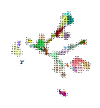

In [716]:
figsize =(1.5, 1.3)
fig = plt.figure(None,figsize)  
ax = fig.add_axes([0, 0, 0.8, 1])
adata_var_1.uns['Clusters_colors'] = clu_colour
scv.pl.velocity_embedding_grid(adata_var_1, basis='Embedding',color='Clusters',\
                             figsize=(1.5,1.3),dpi=400,rasterized=True,s=2.5,title='',show=False ,ax=ax)
fname = ofolder+f'/velocity_on_tsne.svg'
plt.savefig(fname, format="svg", dpi=400, bbox_inches='tight',transparent =transparency)

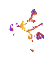

In [1001]:
figsize =(0.67,0.65)#(1.5, 1.3) #s=1
fig = plt.figure(None,figsize)  
ax = fig.add_axes([0, 0, 0.8, 1])
scv.pl.scatter(adata_var_1, basis='Embedding',color='latent_time',color_map='gnuplot_r',\
                             figsize=(0.67,0.65),dpi=400,rasterized=True,s=0.1,title='',show=False ,ax=ax,\
              colorbar=False)
fname = ofolder+f'/latenttime_on_tsne.svg'
plt.savefig(fname, format="svg", dpi=400, bbox_inches='tight',transparent =transparency)



In [1003]:
normalize = Normalize(vmin = 0, vmax = 1)
colorbar = dict({'sm':cm.ScalarMappable(cmap='gnuplot_r'),
                            'vmin':0,
                            'vmax':1})
name = 'latenttime_on_tsne'
ax_size =[0.91,0,0.005,0.10]
tmp = scatterm_mod.draw_colorbar(colorbar,ax_size,cticks=[0,1])
fname = ofolder+f'/{name}_legend.svg'
plt.show()
tmp.savefig(fname, format="svg", dpi=144, bbox_inches='tight')




In [1633]:
pick = pick_cells(adata_var_1,g_i=17,groupby='Clusters')
x = []
y = []
cell_iloc =[]
for i in (pick):
    xy, cell_iloc_ = single_get_cell_transitions(adata_var_1, key='T_combined_fwd_xx',basis='Embedding',\
                                          starting_cell=i,n_steps=100,n_neighbors=15)
    cell_iloc.append(cell_iloc_)
    x.append(xy[0])
    y.append(xy[1])

#np.savetxt(ofolder+'walk_cell_iloc.txt',cell_iloc,fmt='%s')

## Open saved random walks

In [102]:
with open(f'{ofolder}/walk_cell_iloc.txt','r') as f:
    line = f.readlines()
    
start = []
end = []
for i,l in enumerate(line):
    if '[' in l:
        start.append(i)
    if ']' in l:
        end.append(i)
start_end = tuple(zip(start,end))

In [99]:
cell_iloc=[]
for i,val in enumerate(start_end):
    start,end = val[0], val[1]
    
    walk_tidy = []
    walk = line[start:end+1]
    for w_i in walk:
        w_i = w_i.strip('\n').strip('[').strip(']')
        w_i = (w_i.split(' '))
        w_i = np.array(w_i)[np.isin(w_i,'',invert=True)]
        w_i = w_i.astype(np.int32)
        walk_tidy.append(w_i)
    walk_tidy = [w for s in walk_tidy for w in s]   
    cell_iloc.append(walk_tidy)

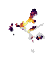

In [971]:

figsize =(0.67,0.65)#(1.5, 1.3)
fig = plt.figure(None,figsize)  
ax = fig.add_axes([0, 0, 0.8, 1])
x,y  = adata_var_1.obsm['Embedding'][:,0], adata_var_1.obsm['Embedding'][:,1]
plt.scatter(x,y,color = 'lightgrey',s=0.1,rasterized=True,alpha=1,lw=0) #0.5

for i in np.arange(len(cell_iloc)): 
    c_i = cell_iloc[i]
    x_,y_ = adata_var_1.obsm['Embedding'][c_i,:][:,0],adata_var_1.obsm['Embedding'][c_i,:][:,1]

    ax.scatter(x_,y_,c = np.linspace(0,1, len(c_i)),cmap='inferno_r',rasterized=True,s=0.5,alpha=1,lw=0)
    
for pos in ["top", "left","bottom", "right"]:
            ax.spines[pos].set_visible(False)
            
ax.tick_params(
    top=False,
    bottom=False,
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False,
)


fname = ofolder+f'/randomwalk.svg'
plt.savefig(fname, format="svg", dpi=400, bbox_inches='tight',transparent =transparency)

In [1024]:
normalize = Normalize(vmin = 0, vmax = 1)
colorbar = dict({'sm':cm.ScalarMappable(cmap='inferno_r'),
                            'vmin':0,
                            'vmax':1})
name = 'randomwalk'
ax_size =[0.91,0,0.005,0.10]
tmp = scatterm_mod.draw_colorbar(colorbar,ax_size,cticks=[0,1])
fname = ofolder+f'/{name}_legend.svg'
plt.show()
tmp.savefig(fname, format="svg", dpi=144, bbox_inches='tight')




## walk to EN1+ cluster

In [1097]:
b00l = np.isin(adata_var_1.obs['Clusters'].values,[24])
clu_idx = b00l.nonzero()[0]
final = []
for i,v in enumerate(cell_iloc):
#     print(v)
    if np.all(np.isin(v[-3:], clu_idx)):
        final.append(i)


final_cell = []
for i in np.arange(len(cell_iloc)): #36 # diffus emed :1:
    if i in final:
        c_i = cell_iloc[i]
        final_cell.append(c_i)
        

squeeze_cellid_idx = np.unique([i for s in final_cell for i in s])
squeeze_cellid_24 = adata_var_1.obs.index[squeeze_cellid_idx]

## walk to PITX2+ cluster

In [1101]:
b00l = np.isin(adata_var_1.obs['Clusters'].values,[34])
clu_idx = b00l.nonzero()[0]
final = []
for i,v in enumerate(cell_iloc):
#     print(v)
    if np.all(np.isin(v[-3:], clu_idx)):
        final.append(i)


final_cell = []
for i in np.arange(len(cell_iloc)): #36 # diffus emed :1:
    if i in final:
        c_i = cell_iloc[i]
        final_cell.append(c_i)
        

squeeze_cellid_idx = np.unique([i for s in final_cell for i in s])
squeeze_cellid_34 = adata_var_1.obs.index[squeeze_cellid_idx]

In [1102]:
overlap_cellid = np.intersect1d(squeeze_cellid_24,squeeze_cellid_34)

b00l = np.isin(squeeze_cellid_24,overlap_cellid,invert=True)
b00l = np.isin(adata_var_1.obs_names,squeeze_cellid_24[b00l])
squeeze_cellid_24_tidy = adata_var_1.obs_names[b00l]

b00l = np.isin(squeeze_cellid_34,overlap_cellid,invert=True)
b00l = np.isin(adata_var_1.obs_names,squeeze_cellid_34[b00l])
squeeze_cellid_34_tidy = adata_var_1.obs_names[b00l]

In [3265]:
# np.savetxt(ofolder+'final_clu34.txt',squeeze_cellid_34_tidy.values,fmt='%s')
# np.savetxt(ofolder+'final_clu34.txt',squeeze_cellid_24_tidy.values,fmt='%s')

## plot for walk to EN1+ cluster

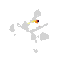

In [1103]:
b00l = np.isin(adata_var_1.obs['Clusters'].values,[24])
clu_idx = b00l.nonzero()[0]
final = []
for i,v in enumerate(cell_iloc):
#     print(v)
    if np.all(np.isin(v[-3:], clu_idx)):
        final.append(i)


final_cell = []
for i in np.arange(len(cell_iloc)):
    if i in final:
        c_i = cell_iloc[i]
        final_cell.append(c_i)
        

squeeze_cellid_idx = np.unique([i for s in final_cell for i in s])
squeeze_cellid_24 = adata_var_1.obs.index[squeeze_cellid_idx]

magnitude = 0.5
figsize =(1.5*magnitude, 1.3*magnitude)
fig = plt.figure(None,figsize)  
ax = fig.add_axes([0, 0, 0.8, 1])

x,y  = adata_var_1.obsm['Embedding'][:,0], adata_var_1.obsm['Embedding'][:,1]
plt.scatter(x,y,c = 'lightgrey',s=0.5,rasterized=True,lw=0)
final_cell = []
for i in np.arange(len(cell_iloc)):
    if i in final:
        c_i = cell_iloc[i]
        b00l = np.isin(adata_var_1.obs_names[c_i],overlap_cellid,invert=True)
        c_i = np.array(c_i)[b00l]
        final_cell.append(c_i)
        x_,y_ = adata_var_1.obsm['Embedding'][c_i,:][:,0],adata_var_1.obsm['Embedding'][c_i,:][:,1]
        ax.scatter(x_,y_,c = np.linspace(0,1, len(c_i)),cmap='inferno_r',s=0.5,rasterized=True,lw=0)
for pos in ["top", "left","bottom", "right"]:
            ax.spines[pos].set_visible(False)
            
ax.tick_params(
    top=False,
    bottom=False,
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False,
)


fname = ofolder+f'/walk_24.svg'
# plt.savefig(fname, format="svg", dpi=400, bbox_inches='tight',transparent =transparency)

## plot for walk to PITX2+ cluster

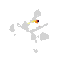

In [1103]:
b00l = np.isin(adata_var_1.obs['Clusters'].values,[24])
clu_idx = b00l.nonzero()[0]
final = []
for i,v in enumerate(cell_iloc):
#     print(v)
    if np.all(np.isin(v[-3:], clu_idx)):
        final.append(i)


final_cell = []
for i in np.arange(len(cell_iloc)):
    if i in final:
        c_i = cell_iloc[i]
        final_cell.append(c_i)
        

squeeze_cellid_idx = np.unique([i for s in final_cell for i in s])
squeeze_cellid_24 = adata_var_1.obs.index[squeeze_cellid_idx]

magnitude = 0.5
figsize =(1.5*magnitude, 1.3*magnitude)
fig = plt.figure(None,figsize)  
ax = fig.add_axes([0, 0, 0.8, 1])

x,y  = adata_var_1.obsm['Embedding'][:,0], adata_var_1.obsm['Embedding'][:,1]
plt.scatter(x,y,c = 'lightgrey',s=0.5,rasterized=True,lw=0)
final_cell = []
for i in np.arange(len(cell_iloc)):
    if i in final:
        c_i = cell_iloc[i]
        b00l = np.isin(adata_var_1.obs_names[c_i],overlap_cellid,invert=True)
        c_i = np.array(c_i)[b00l]
        final_cell.append(c_i)
        x_,y_ = adata_var_1.obsm['Embedding'][c_i,:][:,0],adata_var_1.obsm['Embedding'][c_i,:][:,1]
        ax.scatter(x_,y_,c = np.linspace(0,1, len(c_i)),cmap='inferno_r',s=0.5,rasterized=True,lw=0)
for pos in ["top", "left","bottom", "right"]:
            ax.spines[pos].set_visible(False)
            
ax.tick_params(
    top=False,
    bottom=False,
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False,
)


fname = ofolder+f'/walk_34.svg'
# plt.savefig(fname, format="svg", dpi=400, bbox_inches='tight',transparent =transparency)

In [19]:
load_34 = np.loadtxt(f'{ofolder}/final_clu34.txt',dtype='str')
load_24 = np.loadtxt(f'{ofolder}/final_clu24.txt',dtype='str')

## for identifying lineages associated genes

In [12]:
sys.path.append(os.path.join(current_dir,'lineages_params/species/'))
from scvelo_helper import mask_genes


In [15]:
from scvelo_helper import mask_genes
from cellrank._utils._utils import _correlation_test
mask_cat = ["cellcycle","sex", "ieg", "mt"]

from cellrank.pl._utils import (
    _fit_bulk,
    _get_backend,
    _callback_type,
    _create_models,
    _time_range_type,
    _create_callbacks,
    _get_sorted_colors,
    _input_model_type,
    _return_model_type,
    _get_categorical_colors,
)

from cellrank.ul._utils import (
    _get_n_cores
)
from cellrank.tl._utils import _min_max_scale
import gget


from collections import Iterable, defaultdict
import matplotlib.colors as mcolors

import numpy_groupies as npg


In [37]:
import scanpy
import anndata
from scipy.sparse.csr import csr_matrix

import shoji
db = shoji.connect()


ws = db.builds.sten.humandev20220523.MidbrainTHneighbours_split_clean_sex

ca_attrs = ['CellID','Age']
obs_dict = dict()
for a in ca_attrs:
    obs_dict[a] = ws[a][:]

ra_attr = ['Gene','Accession']
var_dict = dict()
for a in ra_attr:
    var_dict[a] = ws[a][:]

orig = anndata.AnnData(X = csr_matrix(ws.Expression[:]).T.tocsr(),
                        obs = dict(obs_dict),
                        var = dict(var_dict))


orig.var.index = orig.var.Gene.values
orig.obs.index = orig.obs.CellID.values

orig.var_names_make_unique('_')



Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [17]:
import re
search = re.compile('^RPL|^RPS|^MT')
ribo_gene = []
for i in orig.var.index:
    if search.search(i):
        ribo_gene.append(i)

In [69]:
def gene_lineage(walks):
    
    orig.obs['latent_time'] = adata_var_1.obs['latent_time']

    mask_cat = ["cellcycle","sex", "ieg", "mt"]

    b00l = np.isin(orig.obs.index,walks)


    orig_ = orig[b00l,:]
    nnz= np.count_nonzero(orig_.X.A,axis=0)
    b00l_var = np.logical_and(nnz > 10, nnz < orig_.shape[0] * 0.8)
    orig_ = orig_[:,b00l_var]

    mask = np.zeros(orig_.shape[1], dtype=bool)
    for cat in mask_cat:
        mask = mask | np.isin(orig_.var.index, mask_genes[cat])

    orig_ = orig_[:, np.logical_not(mask)]
    b00l = np.isin(orig_.var.index,ribo_gene)
    orig_ = orig_[:, np.logical_not(b00l)]

    scv.pp.filter_genes_dispersion(orig_, n_top_genes=5000,flavor = 'svr')
    scv.pp.normalize_per_cell(orig_)
    scv.pp.log1p(orig_)

    model = cr.ul.models.GAM(orig_)

    lineage_class = cr.tl.Lineage(input_array=orig_.obs['latent_time'].values,\
                                  names=['latent'])
    orig_.obsm['to_terminal_states'] = lineage_class
    driver_orig = _correlation_test(orig_.X,\
                                                   Y=lineage_class,
                                                    gene_names=orig_.var.index)
    
    
    
    notnull=~(driver_orig['latent_corr'].isnull())
    driver_orig = driver_orig.loc[notnull,:]
    idx = np.argsort(driver_orig['latent_corr'])[::-1]
    top_cell = driver_orig.iloc[idx,:]
    top_lineage_genes = top_cell.query('latent_qval < 1e-4') 
    b00l = np.isin(adata_var_1.obs.index,walks)

    time_adata = adata_var_1[b00l,:] 
    hist,edges = np.histogram(time_adata.obs['latent_time'],bins=4)
    acc = 0
    cellid_bin_ =[]
    for i,v in enumerate(zip(hist,edges)):
        if i< len(edges)-1:
            cellid_bin = time_adata.obs.iloc[np.argsort(time_adata.obs['latent_time'].values)][acc:acc+v[0]].index
            cellid_bin_.append(cellid_bin)
            acc+=v[0]

    time_adata.obs['lineage_Clusters']=np.repeat(0,time_adata.shape[0])
    for i,v in enumerate(cellid_bin_):
        b00l = np.isin(time_adata.obs.index,v)
        time_adata.obs['lineage_Clusters'][b00l] =np.repeat(i,len(b00l))
    time_adata.obs['lineage_Clusters'] = time_adata.obs['lineage_Clusters'].astype('category')
    
    
    if np.array_equal(orig_.obs_names,time_adata.obs_names):
        orig_.obs['lineage_Clusters'] = time_adata.obs['lineage_Clusters'].values
        b00l_var_1 = np.isin(orig_.var.index,top_lineage_genes.index)
        sub_adata = orig_[:,b00l_var_1]

        scanpy.tl.rank_genes_groups(sub_adata, 'lineage_Clusters', method='wilcoxon')

        result = sub_adata.uns['rank_genes_groups']
        groups = result['names'].dtype.names
        rank_result=pd.DataFrame(
            {group + '_' + key: result[key][group]
            for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
    else:
        print(f'CELL ID NOT the SAME!')
        
    bins=4
    gene_in_order = []
    for i in np.arange(bins):
        b00l_0 = rank_result[f'{i}_pvals_adj']<0.005 
        b00l_1 = rank_result[f'{i}_logfoldchanges']>0.1 
        b00l = b00l_0 & b00l_1

        rank_result_thres = rank_result.loc[b00l,:]

        if rank_result_thres.shape[0]>100:
            if i == (bins-1):
                thres = np.percentile(rank_result_thres[f'{i}_logfoldchanges'].values,90)
                b00l = rank_result_thres[f'{i}_logfoldchanges'].values>thres

                rank_result_thres = rank_result_thres.loc[b00l,:]
        else:
            if i == (bins-1):
                thres = np.percentile(rank_result_thres[f'{i}_logfoldchanges'].values,50)
                b00l = rank_result_thres[f'{i}_logfoldchanges'].values>thres

                rank_result_thres = rank_result_thres.loc[b00l,:]


        sort_ = np.argsort(rank_result_thres[f'{i}_logfoldchanges'].values)[::-1]
        result_sorted = rank_result_thres.iloc[sort_]
        gene_in_order.append(result_sorted[f'{i}_names'].values)
        
        tidy_gene_in_order =[]
        for i, v in enumerate(gene_in_order):
            flat = [i for s in tidy_gene_in_order for i in s]
            b00l = np.isin(v,flat,invert=True)
            tidy_gene_in_order.append(v[b00l])
        tidy_gene_in_order = [i for s in tidy_gene_in_order for i in s]


    lineages_out = dict({'tidy_gene_in_order':tidy_gene_in_order,
         'time_adata':time_adata,
         'model':model,
         'top_lineage_genes':top_lineage_genes,
         'sub_adata': sub_adata,
        'orig_':orig_})
        
    return lineages_out


In [70]:
lineages_out_24 = gene_lineage(load_24)

tidy_gene_24 = np.copy(lineages_out_24['tidy_gene_in_order'])

time_bin_24 = dict(zip(lineages_out_24['time_adata'].obs_names,\
                       lineages_out_24['time_adata'].obs['lineage_Clusters'].values))

hist,edges_24 = np.histogram(lineages_out_24['time_adata'].obs['latent_time'],bins=4)
edges_24 = [np.round(i,2) for i in edges_24]

Trying to set attribute `.obs` of view, copying.


Extracted 5000 highly variable genes.
Normalized count data: X, spliced, unspliced.


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `._uns` of view, copying.


In [74]:
lineages_out_34 = gene_lineage(load_34)

tidy_gene_34 = np.copy(lineages_out_34['tidy_gene_in_order'])

time_bin_34 = dict(zip(lineages_out_34['time_adata'].obs_names,\
                       lineages_out_34['time_adata'].obs['lineage_Clusters'].values))

hist,edges_34 = np.histogram(lineages_out_34['time_adata'].obs['latent_time'],bins=4)
edges_34 = [np.round(i,2) for i in edges_34]

Trying to set attribute `.obs` of view, copying.


Extracted 5002 highly variable genes.
Normalized count data: X, spliced, unspliced.


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `._uns` of view, copying.


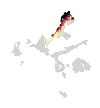

In [26]:
figsize =(1.5, 1.3)
fig = plt.figure(None,figsize)  
ax = fig.add_axes([0, 0, 0.8, 1])

x,y = adata_var_1.obsm['Embedding'][:,0],adata_var_1.obsm['Embedding'][:,1]
ax.scatter(x,y,color='lightgrey',s=1,rasterized=True,alpha=1,lw=0)

time_adata = lineages_out_24['time_adata']
x,y = time_adata.obsm['Embedding'][:,0],time_adata.obsm['Embedding'][:,1]
time_bin = plt.cm.get_cmap('inferno_r', 4)
time_col = dict(zip([i for i in np.arange(len(time_bin.colors))],time_bin.colors))
col = [time_col[i] for i in time_adata.obs['lineage_Clusters']]
ax.scatter(x,y,color=col,s=1,rasterized=True,alpha=1,lw=0)


for pos in ["top", "left","bottom", "right"]:
            ax.spines[pos].set_visible(False)
            
ax.tick_params(
    top=False,
    bottom=False,
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False,
)


fname = ofolder+f'/walk_24_bins.svg'
# plt.savefig(fname, format="svg", dpi=400, bbox_inches='tight',transparent =transparency)

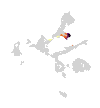

In [28]:
figsize =(1.5, 1.3)
fig = plt.figure(None,figsize)  
ax = fig.add_axes([0, 0, 0.8, 1])

time_adata = lineages_out_34['time_adata']

x,y = adata_var_1.obsm['Embedding'][:,0],adata_var_1.obsm['Embedding'][:,1]
ax.scatter(x,y,color='lightgrey',s=1,rasterized=True,alpha=1,lw=0)

x,y = time_adata.obsm['Embedding'][:,0],time_adata.obsm['Embedding'][:,1]
time_bin = plt.cm.get_cmap('inferno_r', 4)
time_col = dict(zip([i for i in np.arange(len(time_bin.colors))],time_bin.colors))
col = [time_col[i] for i in time_adata.obs['lineage_Clusters']]
ax.scatter(x,y,color=col,s=1,rasterized=True,alpha=1,lw=0)


for pos in ["top", "left","bottom", "right"]:
            ax.spines[pos].set_visible(False)
            
ax.tick_params(
    top=False,
    bottom=False,
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False,
)


fname = ofolder+f'/walk_34_bins.svg'
# plt.savefig(fname, format="svg", dpi=400, bbox_inches='tight',transparent =transparency)

## barplot

In [35]:
gene_24 = ['ASCL1','LMX1A','EN1','NPAS4', 'CUX2','TOX2', 'BNC2','ALDH1A1'][::-1]
gene_34 =['PITX2','BARHL2','BARHL1','ONECUT1','LHX1','EBF1','POU4F1'][::-1]

gene=['ASCL1','PITX2','LMX1A','EN1','NPAS4','CUX2','TOX2','BARHL1','BARHL2','ONECUT1','EBF1','BNC2'][::-1]

gene = ['LMX1A','ASCL1']

In [29]:
import matplotlib.ticker as ticker


def setup(ax):
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(which='major', width=1.00)
    ax.tick_params(which='major', length=5)
    ax.tick_params(which='minor', width=0.75)
    ax.tick_params(which='minor', length=2.5)
    ax.set_ylim(0, 1)
    ax.patch.set_alpha(0.0)

In [48]:
def barplot_lineage(genes_lineage,edges_0,edges_1,time_bin_0,time_bin_1,color_0,color_1):
    """
    edges_0: histogram edges for cluster on the left of the plot
    edges_1: histogram edges for cluster on the right of the plot
    
    time_bin_0: data for cluster left
    tme_bin_1: data for cluster right
    
    """
    height_0 = []
    for i,v in enumerate(genes_lineage):
        b00l = np.isin(orig.obs_names,list(time_bin_0.keys()))
        ixs = own_utils.ixs_thatsort_a2b(orig.obs_names[b00l],list(time_bin_0.keys()))
        exp = np.log2(orig.X[:,orig.var_names==v][b00l][ixs].A+1)
        height = npg.aggregate(list(time_bin_0.values()), np.ravel(exp), func='mean', fill_value=0)
        height_0.append(height)

    height_1 = []
    for i,v in enumerate(genes_lineage):
        b00l = np.isin(orig.obs_names,list(time_bin_1.keys()))
        ixs = own_utils.ixs_thatsort_a2b(orig.obs_names[b00l],list(time_bin_1.keys()))
        exp = np.log2(orig.X[:,orig.var_names==v][b00l][ixs].A+1)
        height = npg.aggregate(list(time_bin_1.values()), np.ravel(exp), func='mean', fill_value=0)
        height_1.append(height)

    fig, axes = plt.subplots(
             figsize=(0.8, 1.5))

    grid = (len(height_0)+1, 2)
    offset = 0
    strip_height = 1
    x = [1,2,3,4]
    for i,v in enumerate(height_0):

        mmin = np.min(np.minimum(height_0[i],height_1[i]))
        mmax = np.max(np.maximum(height_0[i],height_1[i]))

        ax = plt.subplot2grid(grid, (offset, 0), rowspan=strip_height)
        ax.bar(x,height_1[i],color=color_1,width=0.8,align='center')
        plt.axis("off")
        plt.subplots_adjust(hspace=0.2)



        ax_2 = plt.subplot2grid(grid, (offset, 1), rowspan=strip_height)
        ax_2.bar(x,height_0[i],color=color_0,width=0.8,align='center')
        ax_2.set_ylim(ax.get_ylim())
        plt.axis("off")
        plt.subplots_adjust(hspace=0.2)


        plt.text(-0.01,0.5 , genes_lineage[i], horizontalalignment='right', verticalalignment='top',\
                 transform=ax.transAxes, fontsize=5, color="black")

        offset += strip_height

    ax = plt.subplot2grid(grid, (offset, 0), rowspan=strip_height)
    setup(ax)
    ax.set_xlim(np.min(edges_0)-0.01,np.max(edges_0)+0.01)
    ax.set_xticks(edges_0)
    plt.xticks(rotation = 90,fontsize=5)
    ax.tick_params('x',width=0.2,length=3)
    ax.spines['bottom'].set_linewidth(0.5)

    ax = plt.subplot2grid(grid, (offset, 1), rowspan=strip_height)
    setup(ax)
    ax.set_xlim(np.min(edges_1)-0.01,np.max(edges_1)+0.01)
    ax.set_xticks(edges_1)
    plt.xticks(rotation = 90,fontsize=5)
    ax.tick_params('x',width=0.2,length=3,pad=0)
    ax.spines['bottom'].set_linewidth(0.5)

    

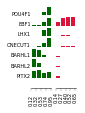

In [49]:
barplot_lineage(gene_34,edges_24,edges_34,time_bin_24,time_bin_34,color_1='darkgreen',color_0='crimson')

fname = ofolder+f'/gene_34.svg'
# plt.savefig(fname, format="svg", dpi=100, bbox_inches='tight',transparent =transparency)
plt.show()

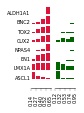

In [50]:
barplot_lineage(gene_24,edges_34,edges_24,time_bin_34,time_bin_24,color_0='darkgreen',color_1='crimson')


fname = ofolder+f'/gene_24.svg'
# plt.savefig(fname, format="svg", dpi=100, bbox_inches='tight',transparent =transparency)
plt.show()

## heatmap

In [34]:
# Load
class_dict = os.path.join(current_dir,'cellclasscolor_dict.npy')
class_dict = np.load(class_dict,allow_pickle='TRUE').item()

In [35]:
_N_XTICKS = 10
from matplotlib.ticker import FormatStrFormatter
## adapt from cellrank
def heatmap_x(data,genes:np.array,figsize=(12,8),
              cmap='inferno_r',
              attr:dict=None,attrs_type:np.array=None,
              attrs_color:dict=None, 
              fontsize=6,xlabel=None,highlight=None,skip:str='skip',plot_time=False,**kwargs):
    
    width, height = figsize[0], figsize[1]
    num_strips =len(attr)
    strip_height=1
    attr_strip_height=2
    total_height = len(genes)*strip_height+ attr_strip_height * num_strips 
    fig, axes = plt.subplots(
             figsize=(width, height))

    grid = (total_height, 1)
    offset = 0
    x_min_=[]
    x_max_=[]
    
    data_t = defaultdict(dict)
    for gene, lns in data.items():
                for ln, y in lns.items():
                    data_t[ln][gene] = y
                    
    for lname, models in data_t.items():
        xs = np.array([m.x_test for m in models.values()])
        x_min, x_max = np.nanmin(xs), np.nanmax(xs)
        df = pd.DataFrame([m.y_test for m in models.values()], index=models.keys())

        max_sort = np.argsort(
            np.argmax(df.apply(_min_max_scale, axis=1).values, axis=1)
        )
        df = df.iloc[max_sort[::-1], :]
    
    sele_gene = np.isin(df.index,genes)
    x_min_,x_max_ = np.min(df.loc[sele_gene]),np.max(df.loc[sele_gene])

    attr_sorted = dict()
    
    if attr is not None:
        
        tmin, tmax = np.min(x_min_), np.max(x_max_)
        t = np.array(attr['Latent time'])
        b00l =(t>=tmin) & (t<=tmax)
        order = np.argsort(t[b00l])
        for i,(k,v) in enumerate(attr.items()):
            attr_sorted[k] = np.array(v)[b00l][order]
            
        
    if plot_time:
        attr_sorted = attr_sorted
    else:
        attr_sorted.pop('Latent time')

    for i,(k,v) in enumerate(attr_sorted.items()):
        if attrs_type[i] =='s':
            if attrs_color is None:
                d = mplot.colorize(np.nan_to_num(v))
            else:
                if k in list(attrs_color.keys()):
                    d = np.array([attrs_color[k][v_i] for v_i in v]) 
                else:
                    d = mplot.colorize(np.nan_to_num(v))
                    
            ax = plt.subplot2grid(grid, (offset, 0), rowspan=attr_strip_height)
            offset += attr_strip_height
            plt.imshow(np.expand_dims(d, axis=0), aspect='auto', extent=(np.min(x_min_),np.max(x_max_),0,1),
                       origin='lower',interpolation='nearest',rasterized=True,**kwargs)
                
            plt.text(-0.01,0.9 , k, horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=fontsize, color="black")
        elif attrs_type[i] == 'f':
            d = np.copy(v)
            ax = plt.subplot2grid(grid, (offset, 0), rowspan=attr_strip_height)
            offset += attr_strip_height
            plt.imshow(np.expand_dims(d, axis=0), aspect='auto', cmap=attrs_color[k],  
                       origin='upper',interpolation='nearest',rasterized=True,**kwargs)

            plt.text(-0.01,0.9, k, horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=fontsize, color="black")
        plt.axis("off")
    
#     offset+=strip_height
    gene_pos = 1
    for ax_i, gene in enumerate(df.index):
        if gene in genes:

        
            c = _min_max_scale(df.loc[gene]) 

            ax = plt.subplot2grid(grid, (offset, 0), rowspan=strip_height)
            offset += strip_height
            plt.imshow(np.expand_dims(c, axis=0), aspect='auto', cmap=cmap, vmin=0, vmax=1, \
                       extent=(np.min(x_min_),np.max(x_max_),0,1),\
                         origin='lower',interpolation='nearest',rasterized=True,**kwargs)
            color = 'black'
            labelleft=True
            if highlight is not None: 
                if gene in highlight:
                    color = 'darkred'
                    
            if skip=='skip':
                if (gene_pos%2)!=0:
                    ax.set_yticks([0.5])
                    ax.set_yticklabels([gene], ha="right",size=fontsize,color=color)
#                     plt.text(-0.01, 1.2, gene, horizontalalignment='right', verticalalignment='top', \
#                          transform=ax.transAxes, fontsize=fontsize, color=color)
                else:
                    ax.set_yticks([])
                    ax.set_yticklabels([])
                    labelleft=False
            elif skip=='all':
                ax.set_yticks([])
                ax.set_yticklabels([])
            else:
                ax.set_yticks([0.5])
                ax.set_yticklabels([gene], ha="right",size=fontsize,color=color)
#                 plt.text(-0.01, 1.2, gene, horizontalalignment='right', verticalalignment='top', \
#                          transform=ax.transAxes, fontsize=fontsize, color=color)

            gene_pos+=1
            
            if highlight is not None: 
                if gene in highlight:
                    ax.yaxis.label.set_color('red')

            for pos in ["top", "left","bottom", "right"]:
                ax.spines[pos].set_visible(False)
        
            ax.tick_params('y', length=2, width=0.5, which='major',pad=0.5)
            ax.tick_params(
                top=False,
                bottom=False,
                left=labelleft,
                right=False,
                labelleft=labelleft,
                labelbottom=False,
            )

    plt.subplots_adjust(hspace=0)

    plt.close()    
    return fig


In [72]:
lineages = ['latent']
# kwargs_  = dict()

model = lineages_out_24['model']
top_lineage_genes = lineages_out_24['top_lineage_genes']
orig_ = lineages_out_24['orig_']


models = _create_models(model,top_lineage_genes.index,lineages)
callback = None
time_range = None
backend = "loky"
n_jobs = 1
show_progress_bar = True
kwargs = dict()
kwargs["backward"] = False
kwargs["time_key"] = 'latent_time'
# kwargs['n_test_points']=None
all_models, data, genes, lineages = _fit_bulk(
    models,
    _create_callbacks(orig_, callback, top_lineage_genes.index, lineages, **kwargs),
    top_lineage_genes.index,
    lineages,
    time_range,
    return_models=True,  # always return (better error messages)
    filter_all_failed=True,
    parallel_kwargs={
        "show_progress_bar": show_progress_bar,
        "n_jobs": _get_n_cores(n_jobs, len(top_lineage_genes.index)),
        "backend": _get_backend(models, backend),
    },
    **kwargs,
)

Computing trends using `1` core(s)


  0%|          | 0/1041 [00:00<?, ?gene/s]

did not converge
    Finish (0:00:29)


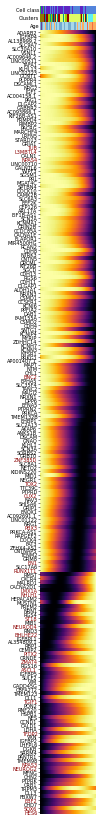

In [73]:
sub_adata = lineages_out_24['sub_adata']
tidy_gene_in_order = lineages_out_24['tidy_gene_in_order']
class_ = [class_dict[i] for i in sub_adata.obs_names]
attr = dict()
attr['Cell class'] = class_
attr_ = ['Age','Clusters','latent_time']
attr_ = (sub_adata.obs[attr_]).to_dict('list')
attr['Clusters'] = [str(i) for i in attr_['Clusters']]
attr['Age'] = [np.round(i,2) for i in attr_['Age']]
attr['Latent time'] = attr_['latent_time']
# attr.pop('latent_time')
tmp = heatmap_x(data,tidy_gene_in_order,figsize=(1,15),attr= attr,attrs_type=np.array(['s','s','f','f']),attrs_color=attr_colour,fontsize=5,\
              highlight=np.array(mask_genes['TFs']),skip='None')
tmp

In [75]:
lineages = ['latent']
# kwargs_  = dict()

model = lineages_out_34['model']
top_lineage_genes = lineages_out_34['top_lineage_genes']
orig_ = lineages_out_34['orig_']



models = _create_models(model,top_lineage_genes.index,lineages)
callback = None
time_range = None
backend = "loky"
n_jobs = 1
show_progress_bar = True
kwargs = dict()
kwargs["backward"] = False
kwargs["time_key"] = 'latent_time'
# kwargs['n_test_points']=None
all_models, data, genes, lineages = _fit_bulk(
    models,
    _create_callbacks(orig_, callback, top_lineage_genes.index, lineages, **kwargs),
    top_lineage_genes.index,
    lineages,
    time_range,
    return_models=True,  # always return (better error messages)
    filter_all_failed=True,
    parallel_kwargs={
        "show_progress_bar": show_progress_bar,
        "n_jobs": _get_n_cores(n_jobs, len(top_lineage_genes.index)),
        "backend": _get_backend(models, backend),
    },
    **kwargs,
)

Computing trends using `1` core(s)


  0%|          | 0/247 [00:00<?, ?gene/s]

did not converge
did not converge
did not converge
did not converge
    Finish (0:00:15)


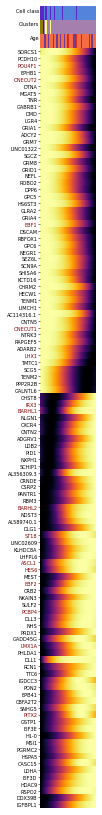

In [76]:
sub_adata = lineages_out_34['sub_adata']
tidy_gene_in_order = lineages_out_34['tidy_gene_in_order']
class_ = [class_dict[i] for i in sub_adata.obs_names]
attr = dict()
attr['Cell class'] = class_
attr_ = ['Age','Clusters','latent_time']
attr_ = (sub_adata.obs[attr_]).to_dict('list')
attr['Clusters'] = [str(i) for i in attr_['Clusters']]
attr['Age'] = [np.round(i,2) for i in attr_['Age']]
attr['Latent time'] = attr_['latent_time']
# attr.pop('latent_time')
tmp = heatmap_x(data,tidy_gene_in_order,figsize=(1,15),attr= attr,attrs_type=np.array(['s','s','f','f']),attrs_color=attr_colour,fontsize=5,\
              highlight=np.array(mask_genes['TFs']),skip='None')
tmp